In [1]:
import torch
import pandas as pd
import os
main_dir = '../wind-profiles/to-test/csvs'
total_size = 640
segment_to_skip = 100

# three dimensional tensors, with shape (len(dir), 640, 9) and (len(dir), 640, 3)
X_test = torch.empty(0, total_size - segment_to_skip, 5)
y_test = torch.empty(0, total_size - segment_to_skip, 3)

for file_ in os.listdir(f'{main_dir}'):
    data = pd.read_csv(f'{main_dir}/{file_}', delimiter=',', 
                    header=0, names=['R','L','n','v','T','B','A/A0','alpha'], 
                    skiprows=0, dtype=float, na_values=['                      NaN', '                     -NaN'])
    
    # if data has NaN values in R column, continue to next file
    if data[['R', 'B', 'A/A0', 'alpha']].isnull().values.any():
        print(f'File {file_} has NaN values in a column')
        continue
    
    # convert to tensor, with shape (len(data), 3), where the three channels are R, B, alpha
    X_sample = torch.tensor(data[['R', 'L', 'B', 'A/A0', 'alpha']].values, dtype=torch.float32)
    y_sample = torch.tensor(data[['n', 'v', 'T']].values, dtype=torch.float32)
    
    X_test = torch.cat((X_test, X_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)
    y_test = torch.cat((y_test, y_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)

In [2]:
main_dir = '../wind-profiles/updated'
#directories = ['CR1992', 'CR2056', 'CR2071', 'CR2125', 'CR2210']
directories = []
total_size = 640
segment_to_skip = 100

torch.set_default_dtype(torch.float64)
torch.set_printoptions(precision=10)
# three dimensional tensors, with shape (len(dir), 640, 9) and (len(dir), 640, 3)
X_data_train = torch.empty(0, total_size - segment_to_skip, 5)
y_data_train = torch.empty(0, total_size - segment_to_skip, 3)
X_data_test = torch.empty(0, total_size - segment_to_skip, 5)
y_data_test = torch.empty(0, total_size - segment_to_skip, 3)

for directory in directories:
    for file_ in os.listdir(f'{main_dir}/Training_files/{directory}'):
        data = pd.read_csv(f'{main_dir}/Training_files/{directory}/{file_}', delimiter=',', 
                        header=0, names=['R', 'L', 'Lon', 'Lat', 'n', 'v', 'T', 'B', 'A/A0', 'alpha', 'V/Cs', 'propag_dt'], 
                        skiprows=2, dtype=float, na_values=['                      NaN', '                     -NaN'])
        
        # if data has NaN values in R column, continue to next file
        if data[['R', 'B', 'alpha', 'n', 'v', 'T']].isnull().values.any():
            continue
        
        # convert to tensor, with shape (len(data), 3), where the three channels are R, B, alpha
        X_sample = torch.tensor(data[['R', 'L', 'B', 'A/A0', 'alpha']].values, dtype=torch.float32)
        y_sample = torch.tensor(data[['n', 'v', 'T']].values, dtype=torch.float32)
        
        X_data_train = torch.cat((X_data_train, X_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)
        y_data_train = torch.cat((y_data_train, y_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)

for directory in directories:
    for file_ in os.listdir(f'{main_dir}/Validation_files/{directory}'):
        data = pd.read_csv(f'{main_dir}/Validation_files/{directory}/{file_}', delimiter=',', 
                        header=0, names=['R', 'L', 'Lon', 'Lat', 'n', 'v', 'T', 'B', 'A/A0', 'alpha', 'V/Cs', 'propag_dt'], 
                        skiprows=2, dtype=float, na_values=['                      NaN', '                     -NaN'])
        
        # if data has NaN values in R column, continue to next file
        if data[['R', 'B', 'alpha', 'n', 'v', 'T']].isnull().values.any():
            continue
        
        # convert to tensor, with shape (len(data), 3), where the three channels are R, B, alpha
        X_sample = torch.tensor(data[['R', 'L', 'B', 'A/A0', 'alpha']].values, dtype=torch.float32)
        y_sample = torch.tensor(data[['n', 'v', 'T']].values, dtype=torch.float32)
        
        X_data_test = torch.cat((X_data_test, X_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)
        y_data_test = torch.cat((y_data_test, y_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
X_test = X_test.permute(0, 2, 1)
y_test = y_test.permute(0, 2, 1)

In [5]:
# load tensors from file
X_train = torch.load('X_data_train.pt')
y_train = torch.load('y_data_train.pt')
X_val = torch.load('X_data_test.pt')
y_val = torch.load('y_data_test.pt')

In [6]:
# train test split
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([9523, 5, 540]),
 torch.Size([370, 5, 540]),
 torch.Size([9523, 3, 540]),
 torch.Size([370, 3, 540]))

In [8]:
X_train[:, 2, :] = torch.abs(X_train[:, 2, :])
X_val[:, 2, :] = torch.abs(X_val[:, 2, :])
X_test[:, 2, :] = torch.abs(X_test[:, 2, :])
X_train[:, 3, :] = torch.abs(X_train[:, 3, :])
X_val[:, 3, :] = torch.abs(X_val[:, 3, :])
X_test[:, 3, :] = torch.abs(X_test[:, 3, :])

In [9]:
import torch

class TensorRobustScaler:
    def __init__(self):
        self.median = None
        self.iqr = None

    def fit(self, X):
        X = X.view(-1)
        self.median = torch.quantile(X, 0.5, dim=-1)
        q1 = torch.quantile(X, 0.25, dim=-1)
        q3 = torch.quantile(X, 0.75, dim=-1)
        self.iqr = q3 - q1

    def transform(self, X):
        return (X - self.median) / self.iqr

    def inverse_transform(self, X):
        return (X * self.iqr) + self.median


def get_normalization_info_inputs(X):
    X_normalized = X.clone()
    normalization_info = {}
    
    for var in [0, 1]:
        X_var = X_normalized[:, var, :]
        X_var_transformed = torch.log1p(X_var)
        mean = X_var_transformed.mean()
        std = X_var_transformed.std()
        normalization_info[var] = {"mean": mean, "std": std, "method": "log_standardization"}
    
    for var in [2, 3]:
        tensor_robust_scaler = TensorRobustScaler()
        X_var = X_normalized[:, var, :]
        X_var_transformed = torch.log1p(X_var)
        tensor_robust_scaler.fit(X_var_transformed)
        normalization_info[var] = {"scaler": tensor_robust_scaler, "method": "log_robust_scaling"}
        
    for var in [4]:
        X_var = X_normalized[:, var, :]
        mean = X_var.mean()
        std = X_var.std()
        normalization_info[var] = {"mean": mean, "std": std, "method": "standardization"}
        
    return normalization_info

def get_normalization_info_outputs(y):
    y_normalized = y.clone()
    normalization_info = {}
    
    for var in [0]:
        y_var = y_normalized[:, var, :]
        y_var_transformed = torch.log1p(y_var)
        mean = y_var_transformed.mean()
        std = y_var_transformed.std()
        normalization_info[var] = {"mean": mean, "std": std, "method": "log_standardization"}
        
    for var in [1, 2]:
        y_var = y_normalized[:, var, :]
        mean = y_var.mean()
        std = y_var.std()
        normalization_info[var] = {"mean": mean, "std": std, "method": "standardization"}
    
    return normalization_info

def normalize(X, normalization_info):
    X_normalized = X.clone()
    
    for var, info in normalization_info.items():
        if info["method"] == "standardization":
            mean = info["mean"]
            std = info["std"]
            X_normalized[:, var, :] = (X_normalized[:, var, :] - mean) / std
        if info["method"] == "log_standardization":
            mean = info["mean"]
            std = info["std"]
            X_normalized[:, var, :] = (torch.log1p(X_normalized[:, var, :]) - mean) / std
        elif info["method"] == "log_robust_scaling":
            scaler = info["scaler"]
            X_normalized[:, var, :] = scaler.transform(torch.log1p(X_normalized[:, var, :]))
    
    return X_normalized

def denormalize(X_normalized, normalization_info):
    X_denormalized = X_normalized.clone()
    
    for var, info in normalization_info.items():
        if info["method"] == "standardization":
            mean = info["mean"]
            std = info["std"]
            X_denormalized[:, var, :] = (X_denormalized[:, var, :] * std) + mean
        if info["method"] == "log_standardization":
            mean = info["mean"]
            std = info["std"]
            X_denormalized[:, var, :] = torch.expm1((X_denormalized[:, var, :] * std) + mean)
        elif info["method"] == "log_robust_scaling":
            scaler = info["scaler"]
            X_denormalized[:, var, :] = torch.expm1(scaler.inverse_transform(X_denormalized[:, var, :]))
    
    return X_denormalized

In [10]:
normalization_info_inputs = get_normalization_info_inputs(X_train)
normalization_info_outputs = get_normalization_info_outputs(y_train)

In [11]:
# normalize data
X_test_normalized = normalize(X_test, normalization_info_inputs).to(torch.float64)
y_test_normalized = normalize(y_test, normalization_info_outputs).to(torch.float64)

In [12]:
X_train_normalized = normalize(X_train, normalization_info_inputs).to(torch.float64)
y_train_normalized = normalize(y_train, normalization_info_outputs).to(torch.float64)

In [13]:
X_val_normalized = normalize(X_val, normalization_info_inputs).to(torch.float64)
y_val_normalized = normalize(y_val, normalization_info_outputs).to(torch.float64)

In [14]:
import torch.nn as nn
import torch.optim as optim

# Model parameters
sequence_length = total_size - segment_to_skip
input_channels = 5
output_channels = 3
batch_size = 32

class SimpleFeedForward(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SimpleFeedForward, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_channels * sequence_length, 2056)
        self.batchnorm1 = nn.BatchNorm1d(2056)
        self.fc2 = nn.Linear(2056, 1024)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.batchnorm3 = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, 2056)
        self.batchnorm4 = nn.BatchNorm1d(2056)
        self.fc5 = nn.Linear(2056, output_channels * sequence_length)
        
        # Do xavier initialization
        layers = [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5]
        for layer in layers:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
            
    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape(batch_size, -1)
        
        x = self.relu(self.batchnorm1(self.fc1(x)))
        x = self.relu(self.batchnorm2(self.fc2(x)))
        x = self.relu(self.batchnorm3(self.fc3(x)))
        x = self.relu(self.batchnorm4(self.fc4(x)))
        x = self.fc5(x)
        
        x = x.reshape(batch_size, self.output_channels, sequence_length)
        
        return x

# Create an instance of the SimpleConvNet
model = SimpleFeedForward(input_channels, output_channels)


In [54]:
# load the best model
model = SimpleFeedForward(input_channels, output_channels)
model.load_state_dict(torch.load('best_model_pinn_fnn_conserv_epoch=250.pth', map_location=device))

model.eval()

SimpleFeedForward(
  (relu): ReLU()
  (fc1): Linear(in_features=2700, out_features=2056, bias=True)
  (batchnorm1): BatchNorm1d(2056, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2056, out_features=1024, bias=True)
  (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (batchnorm3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=1024, out_features=2056, bias=True)
  (batchnorm4): BatchNorm1d(2056, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=2056, out_features=1620, bias=True)
)

In [55]:
# show all test predictions in one plot, show the inputs as well
import matplotlib.pyplot as plt

y_pred = model(X_test_normalized[:, :, :])

# denormalize
y_pred = denormalize(y_pred, normalization_info_outputs).detach().numpy()

In [56]:
# smooth predictions
y_pred_smooth = y_pred.copy()

for i in range(y_pred_smooth.shape[0]):
    for j in range(y_pred_smooth.shape[1]):
        y_pred_smooth[i, j, :] = pd.Series(y_pred_smooth[i, j, :]).rolling(window=8, min_periods=1, win_type='hamming').mean()

In [57]:
# show all test predictions in one plot, show the inputs as well
import matplotlib.pyplot as plt

y_pred_val = model(X_val_normalized[:, :, :])

# denormalize
y_pred_val = denormalize(y_pred_val, normalization_info_outputs).detach().numpy()

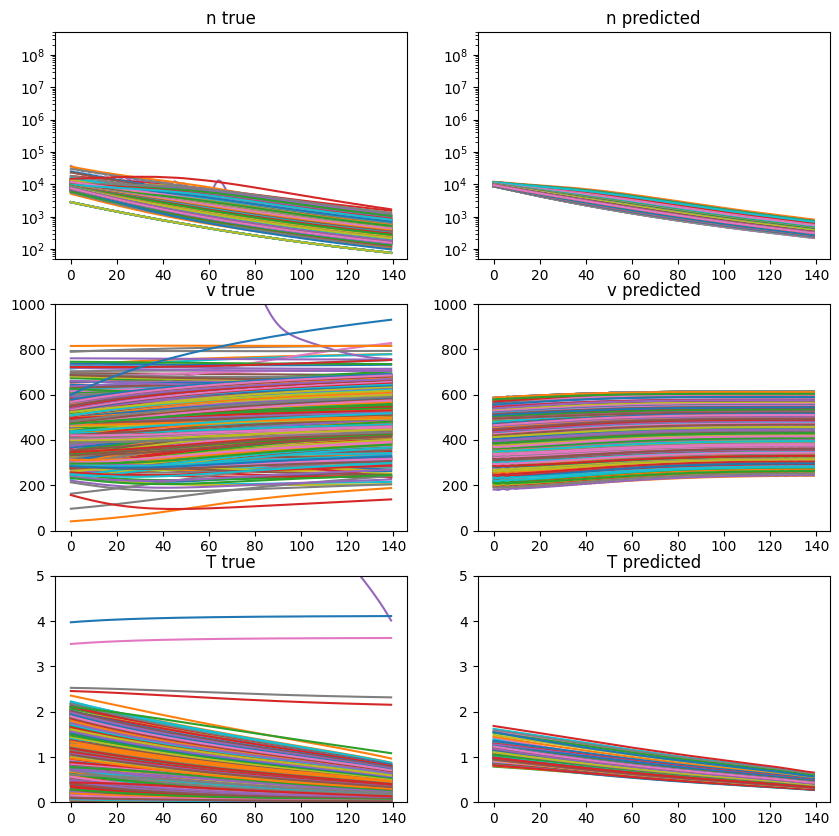

In [58]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

output_names = ['n', 'v', 'T']
lims = [[50, 500000000], [0, 1000], [0, 5]]

for i in range(3):
    axs[i, 0].plot(y_val[:, i, 400:].T)
    axs[i, 0].set_yscale('log') if i == 0 else None
    axs[i, 0].set_ylim(lims[i])
    axs[i, 1].plot(y_pred_val[:, i, 400:].T)
    axs[i, 1].set_yscale('log') if i == 0 else None
    axs[i, 1].set_ylim(lims[i])
    
    axs[i, 0].set_title(f'{output_names[i]} true')
    axs[i, 1].set_title(f'{output_names[i]} predicted')
plt.show()


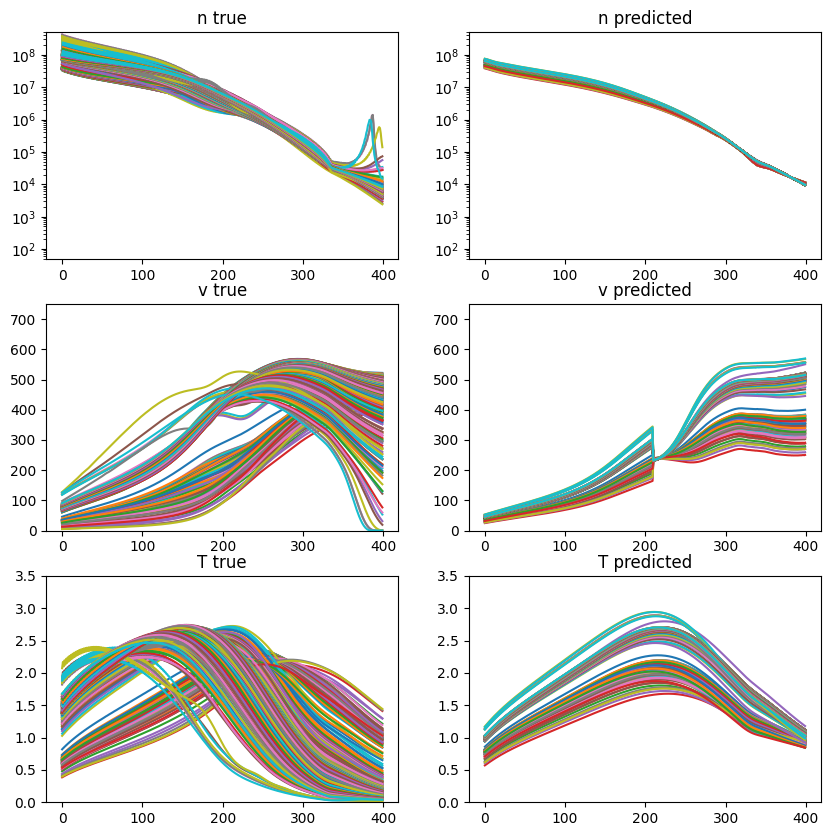

In [59]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

output_names = ['n', 'v', 'T']
lims = [[50, 500000000], [0, 750], [0, 3.5]]

for i in range(3):
    axs[i, 0].plot(y_test[:, i, 400:].T)
    axs[i, 0].set_yscale('log') if i == 0 else None
    axs[i, 0].set_ylim(lims[i])
    axs[i, 1].plot(y_pred[:, i, 400:].T)
    axs[i, 1].set_yscale('log') if i == 0 else None
    axs[i, 1].set_ylim(lims[i])
    
    axs[i, 0].set_title(f'{output_names[i]} true')
    axs[i, 1].set_title(f'{output_names[i]} predicted')
plt.show()


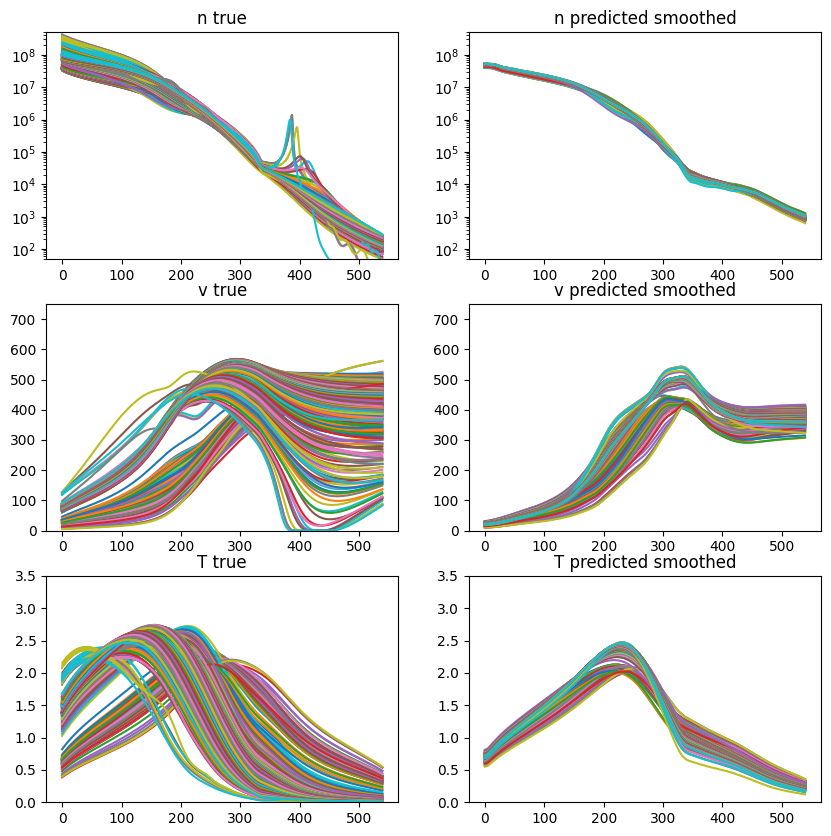

In [62]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

output_names = ['n', 'v', 'T']
lims = [[50, 500000000], [0, 750], [0, 3.5]]

for i in range(3):
    axs[i, 0].plot(y_test[:, i, :].T)
    axs[i, 0].set_yscale('log') if i == 0 else None
    axs[i, 0].set_ylim(lims[i])
    axs[i, 1].plot(y_pred_smooth[:, i, :].T)
    axs[i, 1].set_yscale('log') if i == 0 else None
    axs[i, 1].set_ylim(lims[i])
    
    axs[i, 0].set_title(f'{output_names[i]} true')
    axs[i, 1].set_title(f'{output_names[i]} predicted smoothed')
plt.show()


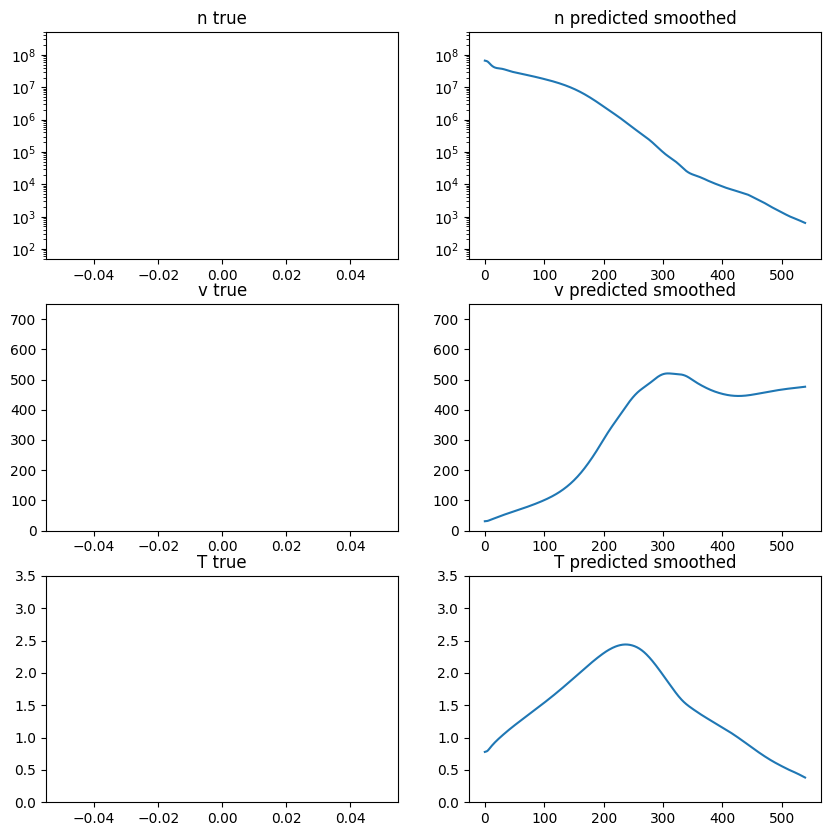

In [55]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

output_names = ['n', 'v', 'T']
lims = [[50, 500000000], [0, 750], [0, 3.5]]

for i in range(3):
    axs[i, 0].plot(y_test[214, i, :].T)
    axs[i, 0].set_yscale('log') if i == 0 else None
    axs[i, 0].set_ylim(lims[i])
    axs[i, 1].plot(y_pred_smooth[214, i, :].T)
    axs[i, 1].set_yscale('log') if i == 0 else None
    axs[i, 1].set_ylim(lims[i])
    
    axs[i, 0].set_title(f'{output_names[i]} true')
    axs[i, 1].set_title(f'{output_names[i]} predicted smoothed')
plt.show()


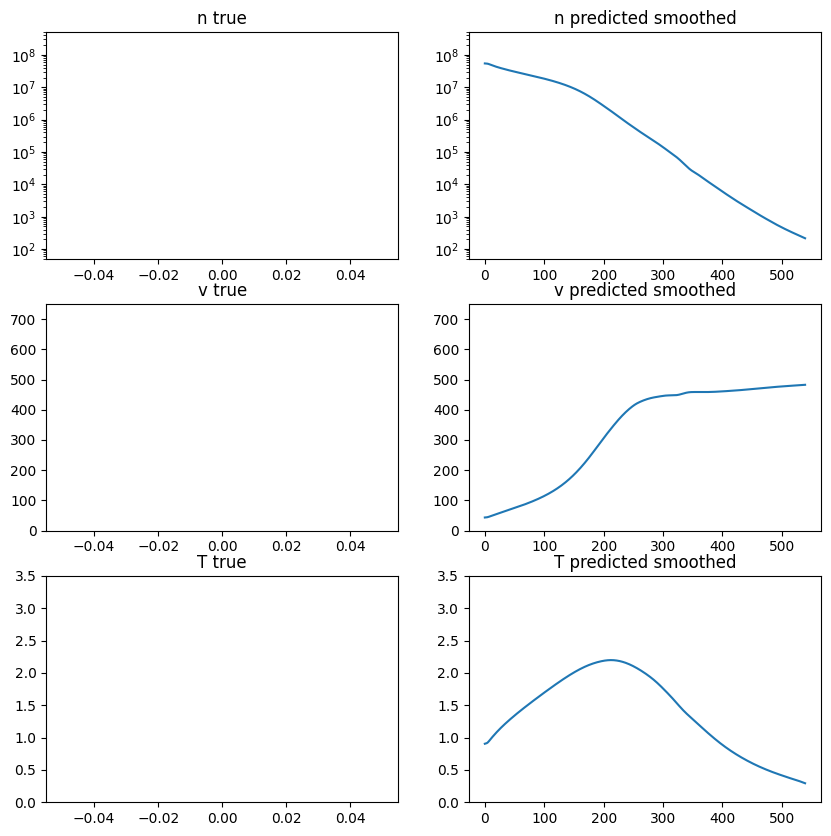

In [42]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

output_names = ['n', 'v', 'T']
lims = [[50, 500000000], [0, 750], [0, 3.5]]

for i in range(3):
    axs[i, 0].plot(y_test[214, i, :].T)
    axs[i, 0].set_yscale('log') if i == 0 else None
    axs[i, 0].set_ylim(lims[i])
    axs[i, 1].plot(y_pred_smooth[214, i, :].T)
    axs[i, 1].set_yscale('log') if i == 0 else None
    axs[i, 1].set_ylim(lims[i])
    
    axs[i, 0].set_title(f'{output_names[i]} true')
    axs[i, 1].set_title(f'{output_names[i]} predicted smoothed')
plt.show()


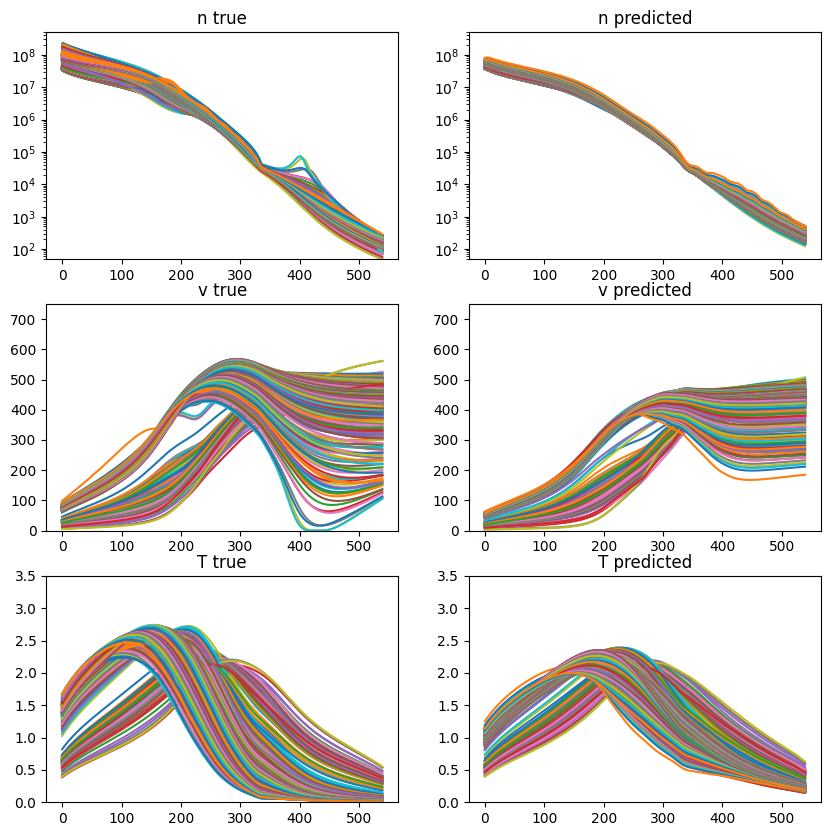

In [20]:
failed_indices = [214, 215, 216, 217, 218, 327, 328]
not_failed_indices = [i for i in range(y_pred.shape[0]) if i not in failed_indices]

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

output_names = ['n', 'v', 'T']
lims = [[50, 500000000], [0, 750], [0, 3.5]]

for i in range(3):
    axs[i, 0].plot(y_test[not_failed_indices, i, :].T)
    axs[i, 0].set_yscale('log') if i == 0 else None
    axs[i, 0].set_ylim(lims[i])
    axs[i, 1].plot(y_pred[not_failed_indices, i, :].T)
    axs[i, 1].set_yscale('log') if i == 0 else None
    axs[i, 1].set_ylim(lims[i])
    
    axs[i, 0].set_title(f'{output_names[i]} true')
    axs[i, 1].set_title(f'{output_names[i]} predicted')
plt.show()




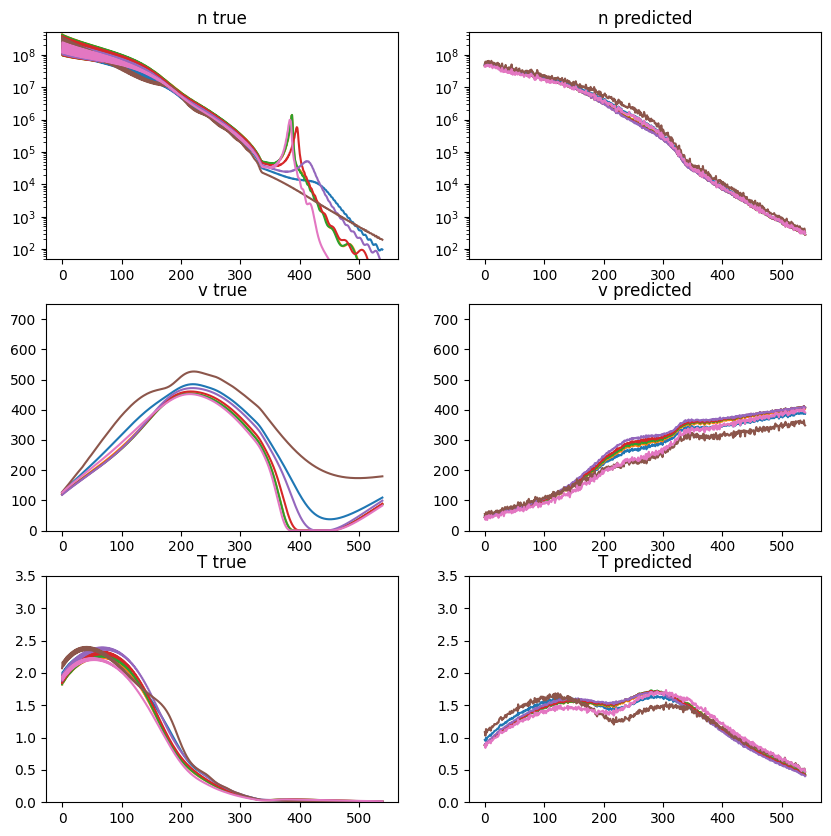

In [21]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

output_names = ['n', 'v', 'T']
lims = [[50, 500000000], [0, 750], [0, 3.5]]

for i in range(3):
    axs[i, 0].plot(y_test[failed_indices, i, :].T)
    axs[i, 0].set_yscale('log') if i == 0 else None
    axs[i, 0].set_ylim(lims[i])
    axs[i, 1].plot(y_pred[failed_indices, i, :].T)
    axs[i, 1].set_yscale('log') if i == 0 else None
    axs[i, 1].set_ylim(lims[i])
    
    axs[i, 0].set_title(f'{output_names[i]} true')
    axs[i, 1].set_title(f'{output_names[i]} predicted')
plt.show()




In [82]:
# output the predictions to a csv file, with R,L,n,v,T,B,A/A0,alpha columns
import numpy as np

def output_to_csv(y_pred, X, folder_name, test_name):
    R = X[:, 0, :].detach().numpy()
    L = X[:, 1, :].detach().numpy()
    B = X[:, 2, :].detach().numpy()
    A_A0 = X[:, 3, :].detach().numpy()
    alpha = X[:, 4, :].detach().numpy()
    
    n = y_pred[:, 0, :]
    v = y_pred[:, 1, :]
    T = y_pred[:, 2, :]
    
    # create a folder to store the csv files
    if not os.path.exists(f'predictions_{folder_name}'):
        os.makedirs(f'predictions_{folder_name}')
    
    for i in range(len(B)):
        df = pd.DataFrame(np.array([R[i], L[i], n[i], v[i], T[i], B[i], A_A0[i], alpha[i]]).T, columns=['R', 'L', 'n', 'v', 'T', 'B', 'A/A0', 'alpha'])
        df.to_csv(f'predictions_{folder_name}/{test_name}_{i + 1:05}.csv', index=False)

In [114]:
model_name = 'pinn_fnn_24_03_2024'
output_to_csv(y_pred, X_test, f'{model_name}_not_smoothed', 'adapt01_20231109230000_linelist')
output_to_csv(y_pred_smooth, X_test, f'{model_name}_smoothed', 'adapt01_20231109230000_linelist')